#Google Drive and RDKit
Mounting the drive installing RDKit

In [ ]:
!pip install pydrive

     |████████████████████████████████| 993kB 3.5MB/s 
  Created wheel for pydrive: filename=PyDrive-1.3.1-cp36-none-any.whl size=27437 sha256=8735c4c3cd561db06bd08e53eadac5154d2e036c4533453882d96ccb08cab27f
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
rdkit_installfile = drive.CreateFile({'id':'1MnNtztDfr8DRIJtwuejlNGtzxvS5wk-1'})
rdkit_installfile.GetContentFile('rdkit_install.py')

In [ ]:
!python rdkit_install.py

add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.8
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
PREFIX=/root/miniconda
Unpacking payload ...
Solving environment: - \ | done

## Package Plan ##

  environment location: /root/miniconda

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==0.24.0=py37_0
    - bzip2==1.0.8=h7b6447c_0
    - ca-certificates==2019.5.15=0
    - certifi==2019.6.16=py37_0
    - cffi==1.12.3=py37h2e261b9_0
    - chardet==3.0.4=py37_1
    - conda-package-handling==1.3.11=py37_0
    - conda==4.7.10=py37_0
    - cryptography==2.7=py37h1ba5d50_0
    - idna==2.8=py37_0
    - libarchive==3.3.3=h5d8350f_5
    - libedit==3.1.20181209=hc058e9b_0
    - libffi==3.2.1=hd88cf55_4
    - libgcc-ng==9.1.0=hdf63c60_0
    - libstdcxx-ng==9.1.0=hdf63c60_0
    - libxml2==2.9.9=hea5a465_1
    - lz4-c==1.8.1.2=h14c3975_0
    - lzo==2.

In [ ]:
#https://iwatobipen.wordpress.com/2018/11/01/run-rdkit-and-deep-learning-on-google-colab-rdkit/

%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/root/miniconda/lib/python3.6/site-packages')


import numpy as np
import json
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

#Model

In [ ]:
functions = '/content/drive/My Drive/functionsCVAE.py'

In [ ]:
from keras import backend as K
from keras import objectives
from keras import optimizers
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D
from keras.layers import concatenate, Permute


charset = [" ", "(", ".", "0", "2", "4", "6", "8", "@", "B", "F", "H", "L", "N", "P", "R", "T", "V", "X", "Z",
            "\\", "b", "d", "l", "n", "p", "r", "t", "#", "%", ")", "+", "-", "/", "1", "3", "5", "7", "9", "=",
            "A", "C", "G", "I", "K", "M", "O", "S", "[", "]", "a", "c", "e", "g", "i", "o", "s", "u"]

class MoleculeCVAE:

    def create(self,
               charset,
               max_length=120,
               latent_rep_size=292,
               cond_size=128,
               weights_file=None):
        charset_length = len(charset)

        x = Input(shape=(max_length, charset_length))

        cond = Input(shape=(cond_size,))
        cond2 = RepeatVector(charset_length)(cond)
        cond3 = Permute((2, 1))(cond2)
        
        inputs = concatenate([x, cond3], axis=-2)

        vae_loss, z = self._buildEncoder(inputs, latent_rep_size, max_length)
        self.encoder = Model([x, cond], z)

        encoded_input = Input(shape=(latent_rep_size + cond_size,))
        self.decoder = Model(
            encoded_input,
            self._buildDecoder(
                encoded_input,
                latent_rep_size,
                max_length,
                charset_length
            )
        )

        vae_loss, z1 = self._buildEncoder(inputs, latent_rep_size, max_length)
        self.autoencoder = Model(
            [x, cond],
            self._buildDecoder(
                concatenate([z, cond]),
                latent_rep_size,
                max_length,
                charset_length
            )
        )

        if weights_file:
            self.autoencoder.load_weights(weights_file)
            self.encoder.load_weights(weights_file, by_name=True)
            self.decoder.load_weights(weights_file, by_name=True)


        self.autoencoder.compile(optimizer = 'Adam',
                                 loss = vae_loss,
                                 metrics = ['accuracy'])

        

    def _buildEncoder(self, x, latent_rep_size, max_length, epsilon_std=0.01):
        h = Convolution1D(9, 9, activation='relu', name='conv_1')(x)
        h = Convolution1D(9, 9, activation='relu', name='conv_2')(h)
        h = Convolution1D(10, 11, activation='relu', name='conv_3')(h)
        h = Flatten(name='flatten_1')(h)
        h = Dense(435, activation='relu', name='dense_1')(h)

        def sampling(args):
            z_mean_, z_log_var_ = args
            batch_size = K.shape(z_mean_)[0]
            epsilon = K.random_normal(shape=(batch_size, latent_rep_size), mean=0., stddev=epsilon_std)
            return z_mean_ + K.exp(z_log_var_ / 2) * epsilon

        z_mean = Dense(latent_rep_size, name='z_mean', activation='linear')(h)
        z_log_var = Dense(latent_rep_size, name='z_log_var', activation='linear')(h)


        def vae_loss(x, x_decoded_mean):
            x = K.flatten(x)
            x_decoded_mean = K.flatten(x_decoded_mean)
            xent_loss = max_length * objectives.binary_crossentropy(x, x_decoded_mean)
            kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
            return xent_loss + kl_loss

        return (vae_loss, Lambda(sampling, output_shape=(latent_rep_size,), name='lambda')([z_mean, z_log_var]))

    def _buildDecoder(self, z, latent_rep_size, max_length, charset_length):
        h = Dense(latent_rep_size, name='latent_input', activation='relu')(z)
        h = RepeatVector(max_length, name='repeat_vector')(h)
        h = GRU(501, return_sequences=True, name='gru_1', reset_after=True, recurrent_activation='sigmoid')(h)
        h = GRU(501, return_sequences=True, name='gru_2', reset_after=True, recurrent_activation='sigmoid')(h)
        h = GRU(501, return_sequences=True, name='gru_3', reset_after=True, recurrent_activation='sigmoid')(h)
        return TimeDistributed(Dense(charset_length, activation='softmax'), name='decoded_mean')(h)

    def save(self, filename):
        self.autoencoder.save_weights(filename)

    def load(self, charset, weights_file, latent_rep_size=292):
        self.create(charset, weights_file=weights_file, latent_rep_size=latent_rep_size)



Using TensorFlow backend.


#Experiments

In [ ]:
#number of dimenions the model was trained with
latent_dim = 292

trained_model = '/content/drive/My Drive/model.hdf5\

charset_file = 'drive/My Drive/Colab Notebooks/CVAE - Thesis/charset.json'
with open('drive/My Drive/Colab Notebooks/CVAE - Thesis/charset.json', 'r') as outfile:
    charset = json.load(outfile)

#from MoleculeCVAE import MoleculeCVAE

model = MoleculeCVAE()
model.load(charset, trained_model)

W0903 17:54:36.454332 140176394958720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 17:54:36.488499 140176394958720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 17:54:36.524210 140176394958720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0903 17:54:36.802965 140176394958720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4409: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0903 17:54:45.233414 140176394958720 deprecation_wra

In [ ]:
import numpy as np 

signatures_file = '/content/drive/My Drive/Colab Notebooks/signature.npy'
signatures = np.load(signatures_file)

smiles_file = '/content/drive/My Drive/Colab Notebooks/smiles.npy'
smiles = np.load(smiles_file)

In [ ]:

smile = ['O=C(c1ccc(F)cc1)C1CCNCC1']
signature = signatures[880]
signature1 = signatures[976]
signature2 = signatures[10]

In [ ]:
##Signatures to correct shape
signature = np.expand_dims(signature, axis=0)
signature1 = np.expand_dims(signature1, axis=0)
signature2 = np.expand_dims(signature2, axis=0)


In [ ]:
signature.shape

(1, 128)

##Original Signature

In [ ]:
def preprocess_smiles(smiles_list):
    cropped = [s.ljust(120) for s in smiles_list]
    preprocessed = np.array([list(map(lambda x: one_hot_array(x, len(CHARSET)), one_hot_index(c))) for c in cropped])
    return preprocessed

#change
from functionsCVAE import smiles_process

p_smile = smiles_process(smile)

In [ ]:
#from functionsCVAE import decode_latent_molecule

rec_smiles = []
for x in range(0,1000):

  smiles_latent = model.encoder.predict([p_smile, signature], batch_size=batch_size)
  
  #NAME
  reconstructed_smiles = decode_latent_molecules(smiles_latent, signature, model)
  lista = reconstructed_smiles.tolist()
  rec_smiles.append(lista)

In [ ]:
flattened  = [val for sublist in rec_smiles for val in sublist]
rec_smiles = flattened

In [ ]:
#checking if smiles' are valid or not

from rdkit import RDLogger

valandnot = []
for x in rec_smiles:
  #removing the errors
  lg = RDLogger.logger()
  lg.setLevel(RDLogger.CRITICAL)
  
  m = Chem.MolFromSmiles(x,sanitize=False)
  if m is None:
    valandnot.append('Invalid')
  else:
    valandnot.append('Valid')
    
    
#checking how many times it was reconstructed as the original SMILES

rec_mols = []
for y in rec_smiles:
  
  #removing the errors 
  lg = RDLogger.logger()
  lg.setLevel(RDLogger.CRITICAL)
  
  #checking if valid
  m = Chem.MolFromSmiles(y,sanitize=False)
  if m is None:
    pass
  else:
    rec_mols.append(y)
    
  
#If 0 smiles reconstructed correctly the function below doesn't work 
    
# comparing original smile with reconstructed
same = []  
for a in rec_mols:
  if a == smile:
    same.append('Same as Original')
  else:
    same.append('Different')

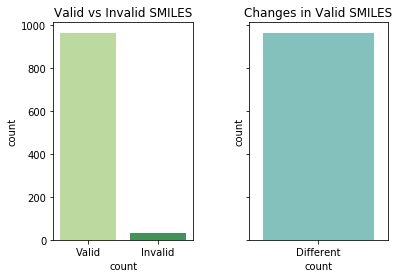

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.DataFrame(valandnot)
df.columns = ['count']
#ax = sns.countplot(x="count", data=df)

df2 = pd.DataFrame(same)
df2.columns = ['count']
#ax2 = sns.countplot(x="count", data=df2)

# Plotting them ide by side
fig, ax =plt.subplots(1,2, sharey=True)
sns.countplot(x="count", data=df,  palette=("YlGn"), ax=ax[0]).set_title('Valid vs Invalid SMILES')
sns.countplot(x="count", data=df2, palette=("GnBu"), ax=ax[1]).set_title('Changes in Valid SMILES')
fig.subplots_adjust(wspace=0.4)
fig.show()

#Barplots with % - change Invalid SMILES and Valid SMILES to numerical data
#ax = sns.barplot(x="count", y="count", data=df, estimator=lambda x: len(x) / len(df) * 100)
#ax.set(ylabel="Percent")
#ax.set_title('Number of Correct (1) and Incorrect (0) SMILES')

In [ ]:
print(set(rec_smiles))

{'O=C(c1ccc(F)cc1)C1CCCCC1', 'O=C(c1ccc(F)cc1)C1CCNCC2', 'O=C(c1ccc(F)cc1)C1CCCCC2', 'O=C(c1ccc(F)cc1)C1CCNCC1'}


###Change in signature

In [ ]:
rec_smiles = []
for x in range(0,1000):

  smiles_latent = model.encoder.predict([p_smile, signature2], batch_size=batch_size)
  
  #NAME
  reconstructed_smiles = decode_latent_molecules(smiles_latent, signature2, model)
  lista = reconstructed_smiles.tolist()
  rec_smiles.append(lista)

In [ ]:
flattened  = [val for sublist in rec_smiles for val in sublist]
rec_smiles = flattened

In [ ]:
#checking if smiles' are valid or not

from rdkit import RDLogger

valandnot = []
for x in rec_smiles:
  #removing the errors
  lg = RDLogger.logger()
  lg.setLevel(RDLogger.CRITICAL)
  
  m = Chem.MolFromSmiles(x,sanitize=False)
  if m is None:
    valandnot.append('Invalid')
  else:
    valandnot.append('Valid')
    
    
#checking how many times it was reconstructed as the original SMILES

rec_mols = []
for y in rec_smiles:
  
  #removing the errors 
  lg = RDLogger.logger()
  lg.setLevel(RDLogger.CRITICAL)
  
  #checking if valid
  m = Chem.MolFromSmiles(y,sanitize=False)
  if m is None:
    pass
  else:
    rec_mols.append(y)
    
  
#If 0 smiles reconstructed correctly the function below doesn't work 
    
# comparing original smile with reconstructed
same = []  
for a in rec_mols:
  if a == smile:
    same.append('Same as Original')
  else:
    same.append('Different')

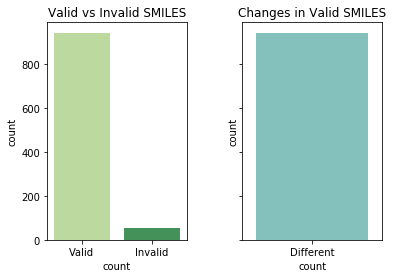

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.DataFrame(valandnot)
df.columns = ['count']
#ax = sns.countplot(x="count", data=df)

df2 = pd.DataFrame(same)
df2.columns = ['count']
#ax2 = sns.countplot(x="count", data=df2)

# Plotting them ide by side
fig, ax =plt.subplots(1,2, sharey=True)
sns.countplot(x="count", data=df,  palette=("YlGn"), ax=ax[0]).set_title('Valid vs Invalid SMILES')
sns.countplot(x="count", data=df2, palette=("GnBu"), ax=ax[1]).set_title('Changes in Valid SMILES')
fig.subplots_adjust(wspace=0.4)
fig.show()

#Barplots with % - change Invalid SMILES and Valid SMILES to numerical data
#ax = sns.barplot(x="count", y="count", data=df, estimator=lambda x: len(x) / len(df) * 100)
#ax.set(ylabel="Percent")
#ax.set_title('Number of Correct (1) and Incorrect (0) SMILES')

In [ ]:
print(set(rec_smiles))

{'O=C(c1ccc(F)cc1)C1CCCCC1', 'O=C(c1ccc(F)cc1)C1CCNCC2', 'O=C(c1ccc(F)cc1)C1CCCCC2', 'O=C(c1ccc(F)cc1)C1CCNCC1'}


In [ ]:
a = Chem.MolFromSmiles('O=C(c1ccc(F)cc1)C1CCCCC1')
b = Chem.MolFromSmiles('O=C(c1ccc(F)cc1)C1CCNCC1')

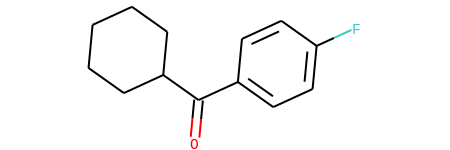

In [ ]:
a

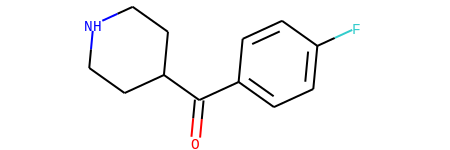

In [ ]:
b

##Sampling from noised latent space

###std=0.05

In [ ]:
latent = model.encoder.predict([p_smile, signature], batch_size=batch_size)

stdev = 0.05
latent_mols = stdev * np.random.randn(1000, latent_dim) + latent

decoded_molecules = []

for lm in latent_mols:
  #decoder outputs (292,) but latent shape should be (1, 292)
  lat = np.expand_dims(lm, axis=0)
  array = decode_latent_molecules(lat, signature, model)
  lista = array.tolist()
  decoded_molecules.append(lista)

flattened  = [val for sublist in decoded_molecules for val in sublist]


/root/miniconda/lib/python3.6/site-packages/rdkit/Chem/Draw/IPythonConsole.py:186: UserWarning: Truncating the list of molecules to be displayed to 30. Change the maxMols value to display more.
  % (maxMols))


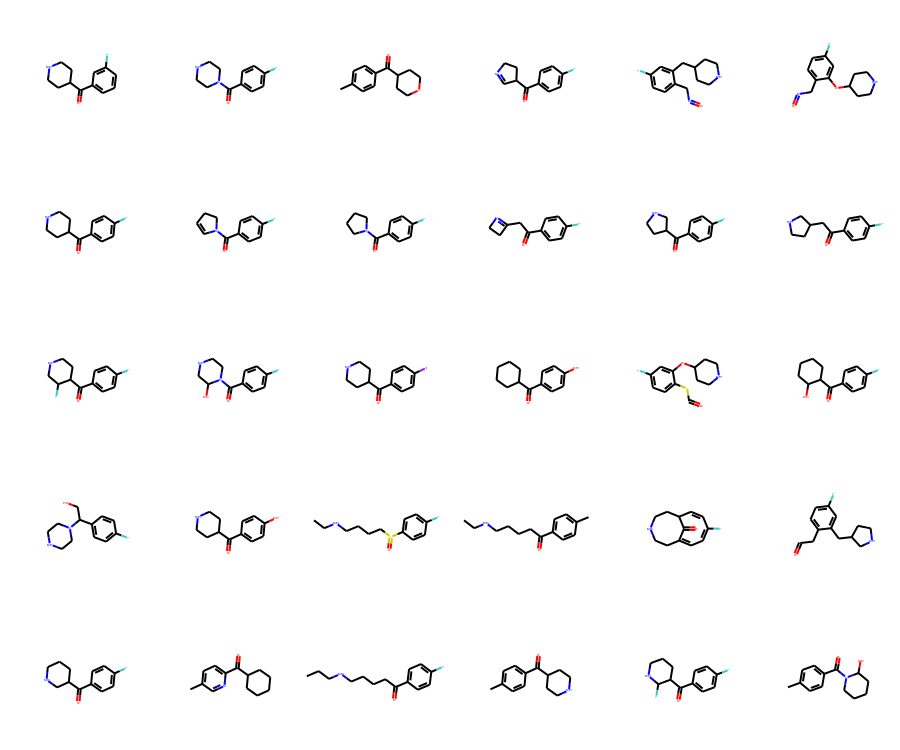

In [ ]:
#Check for valid molecules and plot them 

from rdkit import RDLogger

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

working_mols = []

for smiles in flattened:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            working_mols.append(mol)
    except:
        continue

#getting unique smiles
smiles_list = []
for mol in working_mols:
  smile = Chem.MolToSmiles(mol)
  smiles_list.append(smile)

unique_smiles = set(smiles_list)

#converting smiles back to molecule object that RDKit can plot
molecules_to_plot = []
for smile in unique_smiles:
  mol = Chem.MolFromSmiles(smile)
  molecules_to_plot.append(mol)

       
Draw.MolsToGridImage(molecules_to_plot, molsPerRow=6, subImgSize=(150, 150), maxMols=30)  

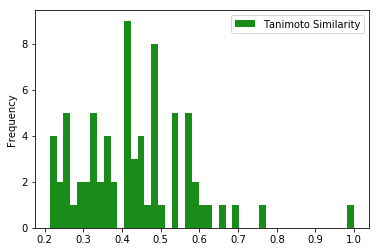

In [ ]:
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

ref = Chem.MolFromSmiles(smile)
ref_morgan = AllChem.GetMorganFingerprint(ref,2)

mol_morgan = []

for mol in molecules_to_plot:
  x = AllChem.GetMorganFingerprint(mol,2)
  mol_morgan.append(x)
  
tanimoto_distance = []

for x in mol_morgan:  
  y = DataStructs.TanimotoSimilarity(ref_morgan,x)
  tanimoto_distance.append(y)
  
import pandas as pd

df = pd.DataFrame(tanimoto_distance, columns = ['Tanimoto Similarity'])
ax = df.plot.hist(bins = 45, alpha=0.9, color='green') #bins = 25

### std=0.1

In [ ]:
latent = model.encoder.predict([p_smile, signature], batch_size=batch_size)

stdev = 0.1
latent_mols = stdev * np.random.randn(1000, latent_dim) + latent

decoded_molecules = []

for lm in latent_mols:
  #decoder outputs (292,) but latent shape should be (1, 292)
  lat = np.expand_dims(lm, axis=0)
  array = decode_latent_molecules(lat, signature, model)
  lista = array.tolist()
  decoded_molecules.append(lista)

flattened  = [val for sublist in decoded_molecules for val in sublist]


/root/miniconda/lib/python3.6/site-packages/rdkit/Chem/Draw/IPythonConsole.py:186: UserWarning: Truncating the list of molecules to be displayed to 30. Change the maxMols value to display more.
  % (maxMols))


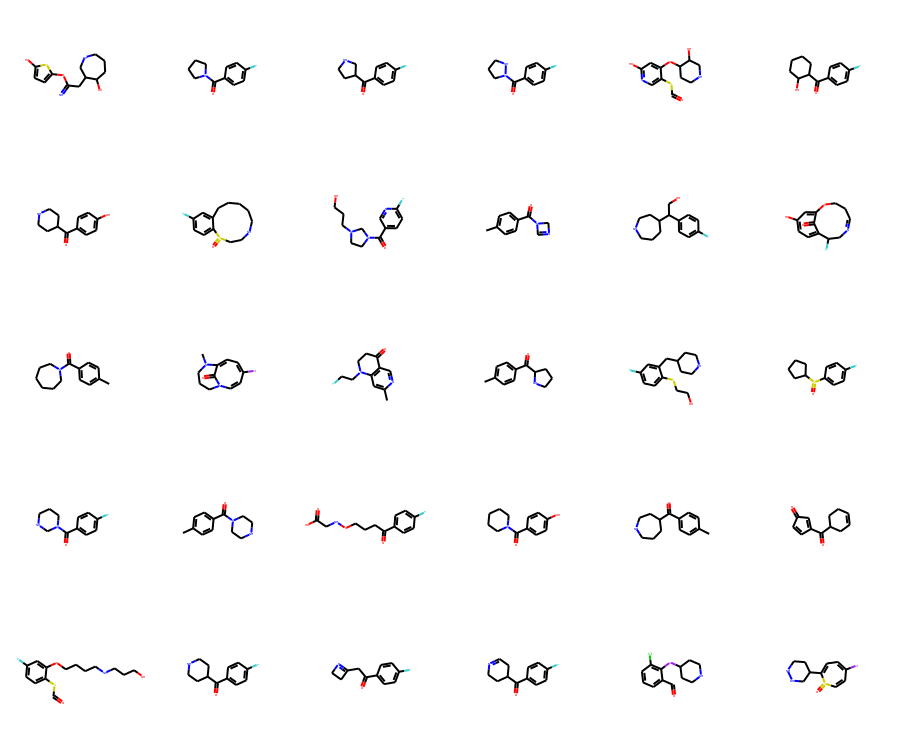

In [ ]:
#Check for valid molecules and plot them 

from rdkit import RDLogger

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

working_mols = []

for smiles in flattened:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            working_mols.append(mol)
    except:
        continue

#getting unique smiles
smiles_list = []
for mol in working_mols:
  smile = Chem.MolToSmiles(mol)
  smiles_list.append(smile)

unique_smiles = set(smiles_list)

#converting smiles back to molecule object that RDKit can plot
molecules_to_plot = []
for smile in unique_smiles:
  mol = Chem.MolFromSmiles(smile)
  molecules_to_plot.append(mol)

       
Draw.MolsToGridImage(molecules_to_plot, molsPerRow=6, subImgSize=(150, 150), maxMols=30)  

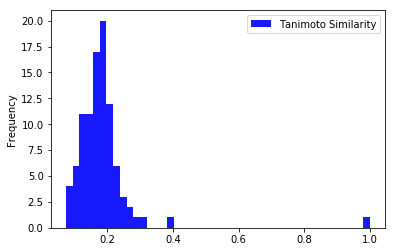

In [ ]:
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

ref = Chem.MolFromSmiles(smile)
ref_morgan = AllChem.GetMorganFingerprint(ref,2)

mol_morgan = []

for mol in molecules_to_plot:
  x = AllChem.GetMorganFingerprint(mol,2)
  mol_morgan.append(x)
  
tanimoto_distance = []

for x in mol_morgan:  
  y = DataStructs.TanimotoSimilarity(ref_morgan,x)
  tanimoto_distance.append(y)
  
import pandas as pd

df = pd.DataFrame(tanimoto_distance, columns = ['Tanimoto Similarity'])
ax = df.plot.hist(bins = 45, alpha=0.9, color='blue') #bins = 25

### std 0.05 different signature

In [ ]:
latent = model.encoder.predict([p_smile, signature2], batch_size=batch_size)

stdev = 0.05
latent_mols = stdev * np.random.randn(1000, latent_dim) + latent

decoded_molecules = []

for lm in latent_mols:
  #decoder outputs (292,) but latent shape should be (1, 292)
  lat = np.expand_dims(lm, axis=0)
  array = decode_latent_molecules(lat, signature2, model)
  lista = array.tolist()
  decoded_molecules.append(lista)

flattened  = [val for sublist in decoded_molecules for val in sublist]


/root/miniconda/lib/python3.6/site-packages/rdkit/Chem/Draw/IPythonConsole.py:186: UserWarning: Truncating the list of molecules to be displayed to 30. Change the maxMols value to display more.
  % (maxMols))


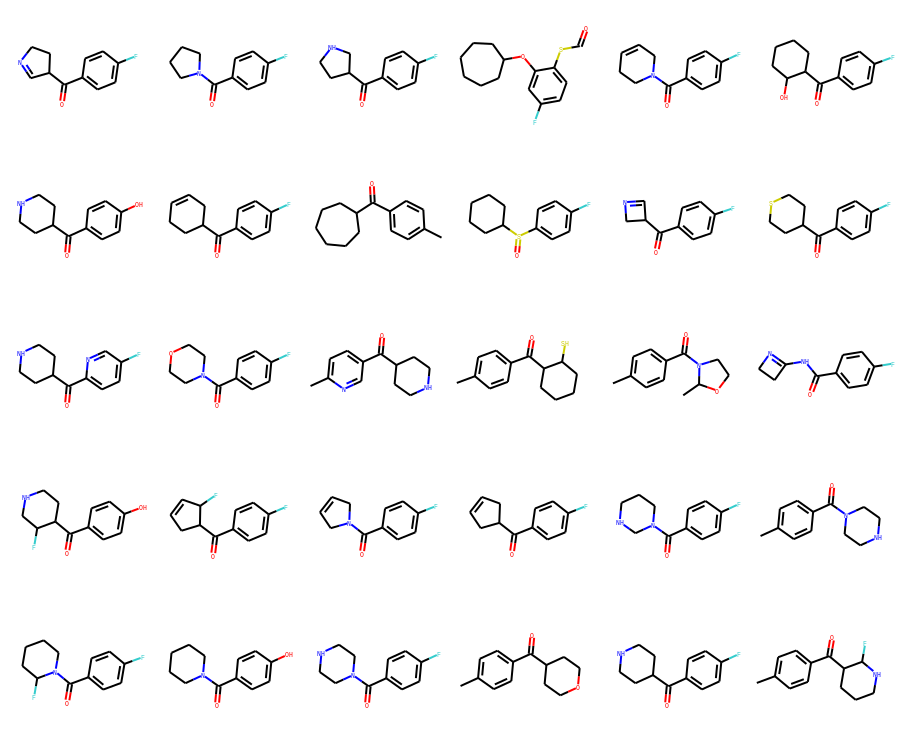

In [ ]:
#Check for valid molecules and plot them 

from rdkit import RDLogger

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

working_mols = []

for smiles in flattened:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            working_mols.append(mol)
    except:
        continue

#getting unique smiles
smiles_list = []
for mol in working_mols:
  smile = Chem.MolToSmiles(mol)
  smiles_list.append(smile)

unique_smiles = set(smiles_list)

#converting smiles back to molecule object that RDKit can plot
molecules_to_plot = []
for smile in unique_smiles:
  mol = Chem.MolFromSmiles(smile)
  molecules_to_plot.append(mol)

       
Draw.MolsToGridImage(molecules_to_plot, molsPerRow=6, subImgSize=(150, 150), maxMols=30)  

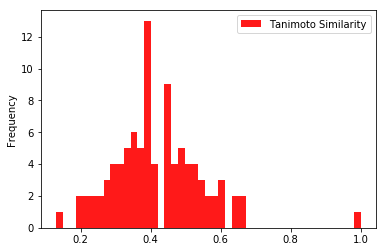

In [ ]:
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

ref = Chem.MolFromSmiles(smile)
ref_morgan = AllChem.GetMorganFingerprint(ref,2)

mol_morgan = []

for mol in molecules_to_plot:
  x = AllChem.GetMorganFingerprint(mol,2)
  mol_morgan.append(x)
  
tanimoto_distance = []

for x in mol_morgan:  
  y = DataStructs.TanimotoSimilarity(ref_morgan,x)
  tanimoto_distance.append(y)
  
import pandas as pd

df = pd.DataFrame(tanimoto_distance, columns = ['Tanimoto Similarity'])
ax = df.plot.hist(bins = 45, alpha=0.9, color='red') #bins = 25

### std = 0.1 different signature

In [ ]:
latent = model.encoder.predict([p_smile, signature2], batch_size=batch_size)

stdev = 0.1
latent_mols = stdev * np.random.randn(1000, latent_dim) + latent

decoded_molecules = []

for lm in latent_mols:
  #decoder outputs (292,) but latent shape should be (1, 292)
  lat = np.expand_dims(lm, axis=0)
  array = decode_latent_molecules(lat, signature2, model)
  lista = array.tolist()
  decoded_molecules.append(lista)

flattened  = [val for sublist in decoded_molecules for val in sublist]


/root/miniconda/lib/python3.6/site-packages/rdkit/Chem/Draw/IPythonConsole.py:186: UserWarning: Truncating the list of molecules to be displayed to 30. Change the maxMols value to display more.
  % (maxMols))


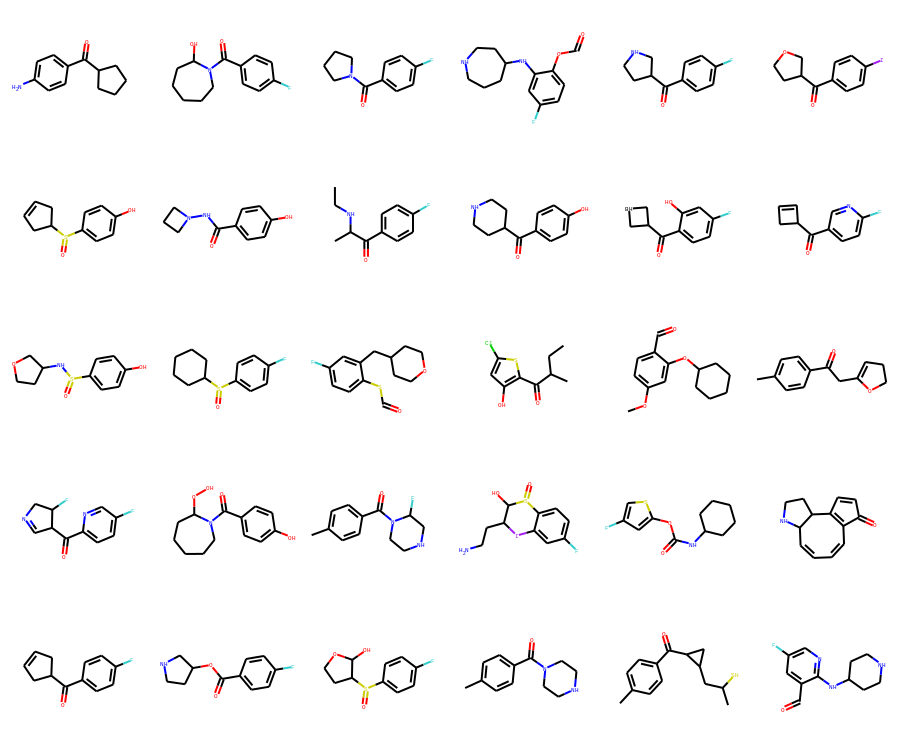

In [ ]:
#Check for valid molecules and plot them 

from rdkit import RDLogger

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

working_mols = []

for smiles in flattened:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            working_mols.append(mol)
    except:
        continue

#getting unique smiles
smiles_list = []
for mol in working_mols:
  smile = Chem.MolToSmiles(mol)
  smiles_list.append(smile)

unique_smiles = set(smiles_list)

#converting smiles back to molecule object that RDKit can plot
molecules_to_plot = []
for smile in unique_smiles:
  mol = Chem.MolFromSmiles(smile)
  molecules_to_plot.append(mol)

       
Draw.MolsToGridImage(molecules_to_plot, molsPerRow=6, subImgSize=(150, 150), maxMols=30)  

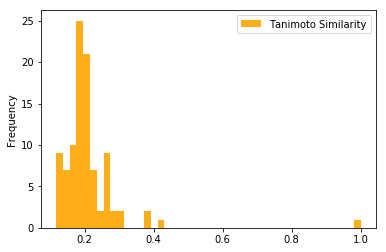

In [ ]:
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

ref = Chem.MolFromSmiles(smile)
ref_morgan = AllChem.GetMorganFingerprint(ref,2)

mol_morgan = []

for mol in molecules_to_plot:
  x = AllChem.GetMorganFingerprint(mol,2)
  mol_morgan.append(x)
  
tanimoto_distance = []

for x in mol_morgan:  
  y = DataStructs.TanimotoSimilarity(ref_morgan,x)
  tanimoto_distance.append(y)
  
import pandas as pd

df = pd.DataFrame(tanimoto_distance, columns = ['Tanimoto Similarity'])
ax = df.plot.hist(bins = 45, alpha=0.9, color='orange') #bins = 25